#  Karlo

pros - conceptually more "stable" outputs
cons - small output size (256x256)

suggestion - apparently can swap out the VAE to the SD unclip 2.1 one, which shouldn't be extremely hard to do.

In [1]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableUnCLIPImg2ImgPipeline, UnCLIPImageVariationPipeline

/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### ADDITIONAL PIPELINE CODE FOR KARLO
pipe = UnCLIPImageVariationPipeline.from_pretrained("kakaobrain/karlo-v1-alpha-image-variations", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_model_cpu_offload()


Loading pipeline components...:  10%|█████▌                                                  | 1/10 [00:00<00:08,  1.11it/s]An error occurred while trying to fetch /home/hew7/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/decoder: Error no file named diffusion_pytorch_model.safetensors found in directory /home/hew7/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/decoder.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  30%|████████████████▊                                       | 3/10 [00:05<00:12,  1.82s/it]An error occurred while trying to fetch /home/hew7/.cache/huggingface/hub/models--kakaobrain--karlo-v1-alpha-image-variations/snapshots/4573828a41f333df688b1111b04add3d9f548331/text_proj: Error no file named diffusion_pytorch_model.safetensors found in dir

In [25]:
# func for getting tensor embeddings from cand image

def load_image(image_dir):
    image = Image.open(image_dir).convert("RGB")
    return image

def load_img_from_URL(URL):
    response = requests.get(URL)
    init_image = Image.open(BytesIO(response.content)).convert("RGB")
    return init_image

def embed_img(input_image):
    tokens = pipe.feature_extractor(input_image)
    img_model = pipe.image_encoder.to('cpu')
    with torch.no_grad():
        embeds = img_model(torch.tensor(tokens.pixel_values[0]).unsqueeze(0))
        
    return embeds.image_embeds.to('cpu')


def localimg_2_embed(image_dir):
    embeds = embed_img(load_image(image_dir))
    return embeds

def URLimg_2_embed(URL):
    embeds = embed_img(load_img_from_URL(URL))
    return embeds


In [4]:
# random generator for softmaxxed outputs

def random_probdist(num_cands):
    random_numbers = torch.randn(num_cands)
    softmax_output = torch.nn.functional.softmax(random_numbers, dim=0).reshape((num_cands,1))
    return softmax_output

In [5]:
def scalesum_candtensors(list_scale, cand_tensors):
    '''
    quick note - just make sure your list_scale is the same length as ur cand_tensors, and also adds up to 1
    '''
    assert sum(list_scale) == 1, f"you didn't input a valid probability distribution - make sure your scales add up to 1, currently it adds up to {sum(list_scale)}"
    assert len(list_scale) == len(cand_tensors), f"your scale list is not the same length as your list of candidate tensors. len list = {len(list_scale)}, len cand tensors = {len(cand_tensors)}"

    scaled = torch.tensor(list_scale), cand_tensors
    output = scaled.sum(dim=0)
    return output
    

def random_candtensor(cand_tensors):
    scaled = random_probdist(len(cand_tensors)) * cand_tensors
    output = scaled.sum(dim=0)
    return output

In [6]:
# for displaying images
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# simpsons char demo

I'm only making this one because I'm lazy and just need characters I can load via URL for a colab demo

In [26]:
homer_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/b/bd/Homer_Simpson.png/revision/latest?cb=20121120224917')
marge_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/d/d5/Marge_Simpson.jpg/revision/latest?cb=20110417084805')
bart_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/1/11/Bart_Simpson.jpg/revision/latest?cb=20120129085633')
lisa_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/e/ec/Lisa_Simpson.png/revision/latest?cb=20121223225143')
maggie_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/9/9d/Maggie_Simpson.png/revision/latest?cb=20121223225248')
grandpa_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/5/5d/Grandpa_Abe_Simpson.png/revision/latest?cb=20121222032244')
patty_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/f/f8/Patty_Bouvier.png/revision/latest?cb=20130414140225')
selma_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/b/ba/Selma_Bouvier.png/revision/latest?cb=20130414140253')
ned_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/d/d2/NedFlanders.png/revision/latest?cb=20130321014614')
moe_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/f/f8/MoeSyzlak.png/revision/latest?cb=20130315001058')
chief_tensor = URLimg_2_embed('https://static.wikia.nocookie.net/scratchpad/images/1/10/ChiefClancyWiggum.png/revision/latest?cb=20130313114954')

In [27]:
simpsons_cand_tensors = torch.cat([homer_tensor,
                                marge_tensor,
                                bart_tensor,
                                lisa_tensor,
                                maggie_tensor,
                                grandpa_tensor,
                                patty_tensor,
                                selma_tensor,
                                ned_tensor,
                                moe_tensor,
                                chief_tensor,
                                   ], dim=0)

In [31]:
simpsons_randomised_input = random_candtensor(simpsons_cand_tensors).unsqueeze(0).half()

In [32]:
output = pipe(image_embeddings=simpsons_randomised_input, num_images_per_prompt=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:07<00:00, 26.76s/it]


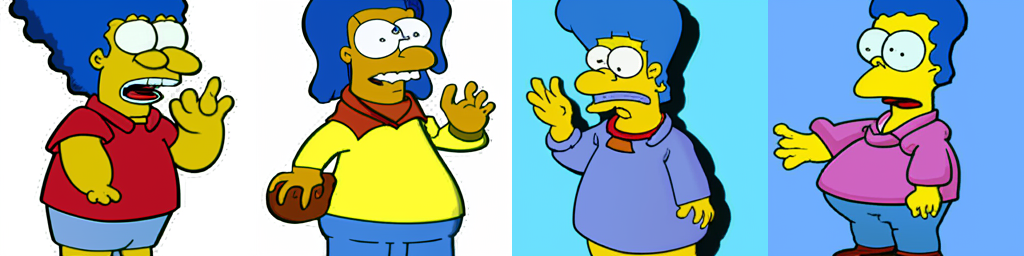

In [33]:
image_grid(output.images, 1,4)

# flux 2 generated examples (based on 11 pictures generated from descs of personas)

In [7]:
#caniddate tensors for flux images

chaos_clicker_tensor = localimg_2_embed('flux2-cand-imgs/chaos-clicker-flux-2.jpg').to('cpu')
content_consr_tensor = localimg_2_embed('flux2-cand-imgs/content-connoisseur-flux-2.jpg').to('cpu')
digital_daydrmr_tensor = localimg_2_embed('flux2-cand-imgs/digital-daydreamer-flux-2.jpg').to('cpu')
eco_explorer_tensor = localimg_2_embed('flux2-cand-imgs/eco-explorer-flux-2.jpg').to('cpu')
fandom_fox_tensor = localimg_2_embed('flux2-cand-imgs/fandom-fox-flux-2.jpg').to('cpu')
meme_maven_tensor = localimg_2_embed('flux2-cand-imgs/meme-maven-flux-2.jpg').to('cpu')
news_nerd_tensor = localimg_2_embed('flux2-cand-imgs/news-nerd-flux-2.jpg').to('cpu')
nostalgic_navgtr_tensor = localimg_2_embed('flux2-cand-imgs/nostalgic-navigator-flux-2.jpg').to('cpu')
scrollseeker_tensor = localimg_2_embed('flux2-cand-imgs/scrollseeker-flux-2.jpg').to('cpu')
social_synth_tensor = localimg_2_embed('flux2-cand-imgs/social-synthesiser-flux-2.jpg').to('cpu')
trend_tracker_tensor = localimg_2_embed('flux2-cand-imgs/trend-tracker-flux-2.jpg').to('cpu')

In [ ]:
flux_cand_tensors = torch.cat([chaos_clicker_tensor,
                content_consr_tensor,
                digital_daydrmr_tensor,
                eco_explorer_tensor,
                fandom_fox_tensor,
                meme_maven_tensor ,
                news_nerd_tensor ,
                nostalgic_navgtr_tensor ,
                scrollseeker_tensor ,
                social_synth_tensor ,
                trend_tracker_tensor ,
               ], dim=0)

In [9]:
flux_randomised_input = random_candtensor(flux_cand_tensors).unsqueeze(0).half()

In [10]:
output = pipe(image_embeddings=flux_randomised_input, num_images_per_prompt=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:17<00:00, 28.22s/it]


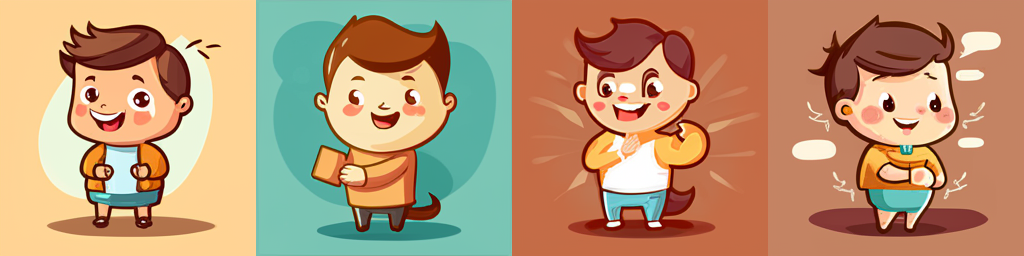

In [11]:
image_grid(output.images, 1,4)


# examples based on arthur imgs

We might have a bit more success with more stylistically consistent images, so I figured I'd just pick characters all from the same tv show.

In [12]:
arthur_tensor = localimg_2_embed('arthur-imgs/arthur.png').to('cpu')
baby_tensor = localimg_2_embed('arthur-imgs/baby.png').to('cpu')
binky_tensor = localimg_2_embed('arthur-imgs/binky.png').to('cpu')
buster_tensor = localimg_2_embed('arthur-imgs/buster.png').to('cpu')
dw_tensor = localimg_2_embed('arthur-imgs/dw.png').to('cpu')
fern_tensor = localimg_2_embed('arthur-imgs/fern.png').to('cpu')
francine_tensor = localimg_2_embed('arthur-imgs/francine.png').to('cpu')
muffy_tensor = localimg_2_embed('arthur-imgs/muffy.png').to('cpu')
pal_tensor = localimg_2_embed('arthur-imgs/pal.png').to('cpu')
ratburn_tensor = localimg_2_embed('arthur-imgs/ratburn.png').to('cpu')
thebrain_tensor = localimg_2_embed('arthur-imgs/thebrain.png').to('cpu')

In [13]:
arthur_cand_tensors = torch.cat([arthur_tensor,
                            baby_tensor,
                            binky_tensor,
                            buster_tensor,
                            dw_tensor ,
                            fern_tensor,
                            francine_tensor,
                            muffy_tensor,
                            pal_tensor,
                            ratburn_tensor,
                            thebrain_tensor,], dim=0)

In [18]:
arthur_randomised_input = random_candtensor(arthur_cand_tensors).unsqueeze(0).half()

In [21]:
output = pipe(image_embeddings=arthur_randomised_input, num_images_per_prompt=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:32<00:00, 30.37s/it]


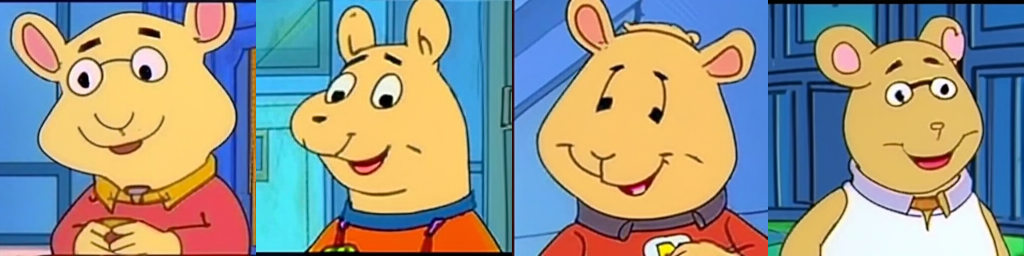

In [22]:
image_grid(output.images, 1,4)